In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from Ancla import Featurizer, RTDataset, BuModel, LandscapeExplorer, BottomUpResNet
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [152]:
training_data = pd.read_csv(r"D:\DB_FullSequencesDistinct_noJurkat.csv")

C:\Users\elabo\AppData\Local\Temp\ipykernel_65896\966019312.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  training_data = pd.read_csv(r"D:\DB_FullSequencesDistinct_noJurkat.csv")


In [153]:
training_data = training_data[training_data['FullSequence'].str.contains('Phospho') | 
                              training_data['FullSequence'].str.contains('Carbamido') | 
                              training_data['FullSequence'].str.contains('Acetyl') | 
                              training_data['FullSequence'].str.contains('Deamid') | 
                              training_data['FullSequence'].str.contains('Oxidation')]

#base sequence less than 50 amino acids
training_data = training_data[training_data['BaseSequence'].str.len() <= 50]

len(training_data)

101218

In [154]:
vocab = pd.read_csv(r"D:\OtherPeptideResultsForTraining\vocab.csv")

# make vocab a dictionary
vocab = dict(zip(vocab["Id"], vocab["Token"]))
#swap keys and values
vocab = {v: k for k, v in vocab.items()}

# change the word Phosphorylation to Phospho
training_data = training_data.replace('Phosphorylation', 'Phospho', regex=True)


In [155]:
example = training_data.iloc[0]
print(example)

Id                                                                             4
AmbiguityLevel                                                                 1
BaseSequence                         ALANVNIGSLICNVGAGGPAPAAGAAPAGGPAPSTAAAPAEEK
FileName                           20100604_Velos1_TaGe_SA_A549_5-calib-averaged
FullSequence                   ALANVNIGSLIC[Common Fixed:Carbamidomethyl on C...
GeneName                                                           primary:RPLP1
MassErrorDaltons                                                        -0.00028
Notch                                                                          0
OrganismName                                                        Homo sapiens
PEP                                                                     0.000029
PEPQvalue                                                               0.000018
PeptideMonoisotopicMass                                               3807.92139
PrecursorCharge             

In [156]:
def feature_vector(peptide, vocab):
    peptide_dictionary = {
        "A" : None, 
        "C" : None,
        "D" : None,
        "E" : None,
        "F" : None,
        "G" : None,
        "H" : None,
        "I" : None,
        "K" : None,
        "L" : None,
        "M" : None,
        "N" : None,
        "P" : None,
        "Q" : None,
        "R" : None,
        "S" : None,
        "T" : None,
        "V" : None,
        "W" : None,
        "Y" : None,
        "Precursor_Charge" : None,
        "Precursor_MZ" : None,
        "Precursor_Mass" : None,
        "Precursor_Scan_Number" : None,
        "Modifications" : None,
        "Polar_Residues" : None,
        "Hydrophobic_Residues" : None,
        "Basic_Residues" : None,
        "Acidic_Residues" : None,
        "Aromatic_Residues" : None,
        "Neutral_Residues" : None,
        "Modification_Monoisotopic_Mass" : None,
    }

    Modifications = {
        "Phospho" : 79.966331,
        "Acetyl" : 42.010565,
        "Carbamido" : 43.005814,
        "Oxidation" : 15.994915,
        "Deamidation" : 0.984016,
    }

    Polar_Residues = ["S", "T", "Y", "N", "Q", "C"]
    Hydrophobic_Residues = ["A", "I", "L", "M", "F", "V", "W"]
    Basic_Residues = ["K", "R", "H"]
    Acidic_Residues = ["D", "E"]
    Aromatic_Residues = ["F", "W", "Y", "H"]
    Neutral_Residues = ["A", "G", "V", "L", "I", "P", "F", "W", "S", "T", "C", "Y", "M", "N", "Q"]
    Retention_Time = peptide["ScanRetentionTime"]

    # fill dictionary with values from example

    # amino acid counts
    for aa in peptide_dictionary.keys():
        peptide_dictionary[aa] = peptide["BaseSequence"].count(aa)

    # precursor charge
    peptide_dictionary["Precursor_Charge"] = peptide["PrecursorCharge"]

    # precursor mz
    peptide_dictionary["Precursor_MZ"] = peptide["PrecursorMZ"]

    # precursor mass
    peptide_dictionary["Precursor_Mass"] = peptide["PrecursorMass"]

    # precursor scan number
    peptide_dictionary["Precursor_Scan_Number"] = peptide["PrecursorScanNumber"]

    # modifications
    modifications = []
    for mod in Modifications.keys():
        if mod in peptide["FullSequence"]:
            modifications.append(mod)
    peptide_dictionary["Modifications"] = modifications

    # polar residues
    polar_residues = 0
    for aa in Polar_Residues:
        if aa in peptide["BaseSequence"]:
            polar_residues += 1
    peptide_dictionary["Polar_Residues"] = polar_residues

    # hydrophobic residues
    hydrophobic_residues = 0
    for aa in Hydrophobic_Residues:
        if aa in peptide["BaseSequence"]:
            hydrophobic_residues += 1
    peptide_dictionary["Hydrophobic_Residues"] = hydrophobic_residues

    # basic residues
    basic_residues = 0
    for aa in Basic_Residues:
        if aa in peptide["BaseSequence"]:
            basic_residues += 1
    peptide_dictionary["Basic_Residues"] = basic_residues

    # acidic residues
    acidic_residues = 0
    for aa in Acidic_Residues:
        if aa in peptide["BaseSequence"]:
            acidic_residues += 1
    peptide_dictionary["Acidic_Residues"] = acidic_residues

    # aromatic residues
    aromatic_residues = 0
    for aa in Aromatic_Residues:
        if aa in peptide["BaseSequence"]:
            aromatic_residues += 1
    peptide_dictionary["Aromatic_Residues"] = aromatic_residues

    # neutral residues
    neutral_residues = 0
    for aa in Neutral_Residues:
        if aa in peptide["BaseSequence"]:
            neutral_residues += 1
    peptide_dictionary["Neutral_Residues"] = neutral_residues

    # modification monoisotopic mass
    modification_monoisotopic_mass = 0
    for mod in modifications:
        modification_monoisotopic_mass += Modifications[mod]
    peptide_dictionary["Modification_Monoisotopic_Mass"] = modification_monoisotopic_mass

    # print(peptide_dictionary)
    peptide_vector = []
    for key in peptide_dictionary.keys():
        if key == "Modifications":
            for mod in peptide_dictionary[key]:
                peptide_vector.append(Modifications[mod])
        else:
            peptide_vector.append(peptide_dictionary[key])

    if len(peptide_vector) != 32:
        return None
    # print(peptide_vector)
    return torch.tensor(peptide_vector, dtype=torch.float32)

In [157]:
# make a list of feature vectors for each peptide in the training data
feature_vectors = []
retention_times = []
for i in range(len(training_data)):
    pept = training_data.iloc[i]
    feature_vector_ = feature_vector(pept, vocab)
    if feature_vector_ is not None:
        feature_vectors.append(feature_vector_)
        retention_times.append(pept["ScanRetentionTime"].astype(float))

# normalize retention times
retention_times = np.array(retention_times)
retention_times = (retention_times - np.min(retention_times)) / (np.max(retention_times) - np.min(retention_times))

#split np array back into list
retention_times = retention_times.tolist()


In [158]:
print(f"Feature vectors: {len(feature_vectors)}, Retention times: {len(retention_times)}")
print(f"Where feature vector length: {len(feature_vectors[0])}")
print(f"Where retention time is: {retention_times[0]}")
print(f"Example feature vector: {feature_vectors[0]}")

Feature vectors: 89678, Retention times: 89678
Where feature vector length: 32
Where retention time is: 0.646907833826927
Example feature vector: tensor([1.4000e+01, 1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 7.0000e+00,
        0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        6.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 1.2703e+03, 3.8079e+03, 0.0000e+00,
        4.3006e+01, 4.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+01, 4.3006e+01])


In [159]:
#make a dataset class
class PeptideDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.feature_vector = data[:]

    def __len__(self):
        return len(self.feature_vector)

    def __getitem__(self, idx):
        return self.feature_vector[idx]

print(f"Feature vectors: {len(feature_vectors)}, Retention times: {len(retention_times)}")

#split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature_vectors, retention_times, test_size=0.2, random_state=42, shuffle=True)

#make the data from a list of list into a list
train_data = list(zip(X_train, y_train))
val_data = list(zip(X_val, y_val))

print(len(train_data), len(val_data))
print(train_data[0])

Feature vectors: 89678, Retention times: 89678
71742 17936
(tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 7.8675e+02, 2.3572e+03, 0.0000e+00,
        4.3006e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        9.0000e+00, 4.3006e+01]), 0.5678829029440545)


In [160]:
train_dataset = PeptideDataset(train_data)
val_dataset = PeptideDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

print(f"Train dataset size: {train_dataset.__len__()}")
print(f"Dataloader size: {train_loader.__len__()}")

#Print first exampole for each dataset
print(train_dataset.__getitem__(0))
print(val_dataset.__getitem__(0))

Train dataset size: 71742
Dataloader size: 2241
(tensor([1.0000e+00, 1.0000e+00, 1.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0000e+00, 7.8675e+02, 2.3572e+03, 0.0000e+00,
        4.3006e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00,
        9.0000e+00, 4.3006e+01]), 0.5678829029440545)
(tensor([4.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 4.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 3.0000e+00, 3.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 4.0000e+00, 7.7141e+02, 3.0816e+03, 0.0000e+00,
        1.5995e+01, 4.0000e+00, 6.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        1.1000e+01, 1.5995e+01]), 0.7000618210995065)


In [164]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 16, 3),
            nn.ReLU(),
            nn.Conv1d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):   
        x = x.unsqueeze(1)
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
model = RegressionModel().to("cuda")

#train the model
criterion = nn.HuberLoss()

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

# LRScheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_epochs = 15
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_loss = 0.0
    val_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        inputs = data[0]
        labels = torch.tensor(data[1].clone().detach(), dtype=torch.float32)
        optimizer.zero_grad()
        outputs = model(inputs.to("cuda"))
        loss = criterion(outputs, labels.unsqueeze(1).to("cuda"))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs.to("cuda"))
            loss = criterion(outputs, labels.unsqueeze(1).to("cuda"))
            val_loss += loss.item()
        val_losses.append(val_loss/len(val_loader))

    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")
    # scheduler.step()


C:\Users\elabo\AppData\Local\Temp\ipykernel_65896\349479972.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(data[1].clone().detach(), dtype=torch.float32)


Epoch 1/15, Train Loss: 0.011765755346337468, Val Loss: 0.00953861739378356
Epoch 2/15, Train Loss: 0.009556709621363435, Val Loss: 0.008945826947871995
Epoch 3/15, Train Loss: 0.00893870471498361, Val Loss: 0.009681716009591973
Epoch 4/15, Train Loss: 0.008645921760948938, Val Loss: 0.008365145526892905
Epoch 5/15, Train Loss: 0.008491027971109585, Val Loss: 0.008209757976666359
Epoch 6/15, Train Loss: 0.008348603484572802, Val Loss: 0.008953043588969324
Epoch 7/15, Train Loss: 0.008241731891400667, Val Loss: 0.008932065106013657
Epoch 8/15, Train Loss: 0.008036576059037244, Val Loss: 0.00809268467918238
Epoch 9/15, Train Loss: 0.007932482162716565, Val Loss: 0.007904975215621692
Epoch 10/15, Train Loss: 0.0078531982204081, Val Loss: 0.007887318201911901
Epoch 11/15, Train Loss: 0.0077397453335613774, Val Loss: 0.0076802931276948325
Epoch 12/15, Train Loss: 0.007722410475311569, Val Loss: 0.007716020867727431
Epoch 13/15, Train Loss: 0.007615566602232751, Val Loss: 0.00822479004605806

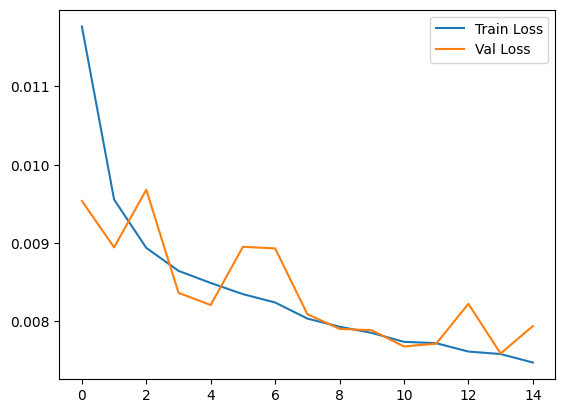

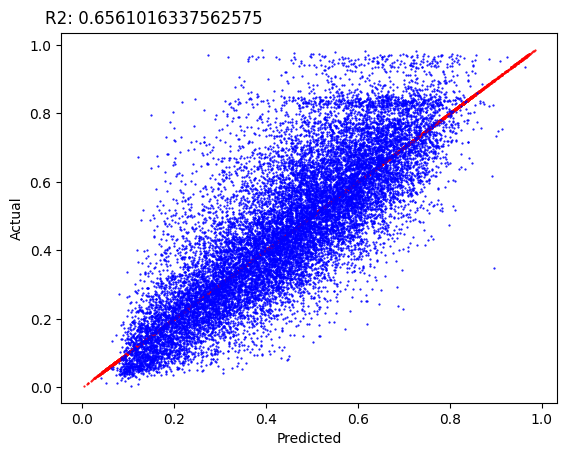

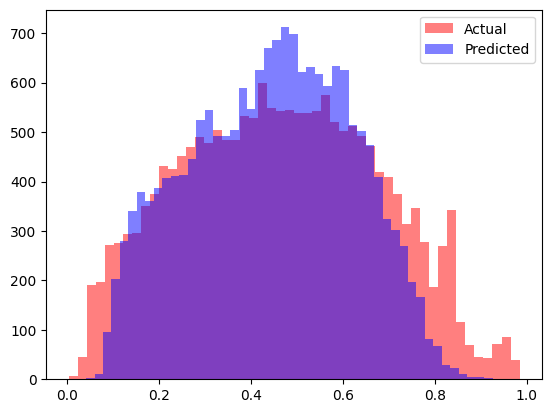

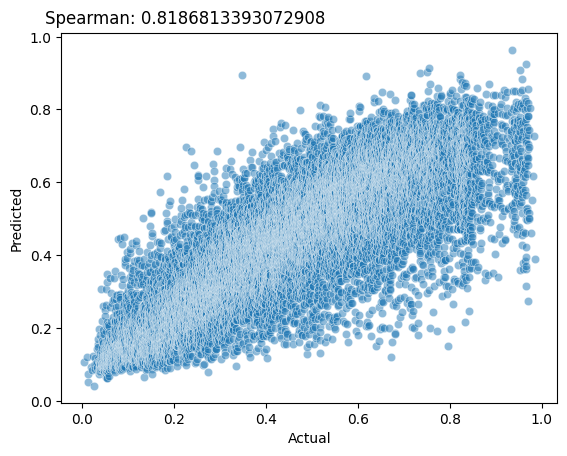

Kendall: 0.6307439242427343


In [165]:

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

# plot predicted vs actual retention times
model.eval()
model.to("cpu")
with torch.no_grad():
    predictions = []
    actuals = []
    for i, data in enumerate(val_loader):
        inputs, labels = data
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(labels.tolist())

plt.scatter(actuals, actuals, s=0.3, c='r')
plt.scatter(predictions, actuals, s=0.3, c='b')
#r2
from sklearn.metrics import r2_score
r2 = r2_score(actuals, predictions)
plt.text(0.1, 0.9, f"R2: {r2}", fontsize=12, transform=plt.gcf().transFigure)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# plot the distribution of the predicted and actual retention times
plt.hist(actuals, bins=50, alpha=0.5, color='r', label='Actual')
plt.hist(predictions, bins=50, alpha=0.5, color='b', label='Predicted')
plt.legend()
plt.show()

# zip the predicted and actual retention times
zipped = list(zip(actuals, predictions))
zipped = sorted(zipped, key=lambda x: x[0])

# make dataframe of the zipped data
df = pd.DataFrame(zipped, columns=["Actual", "Predicted"])
df["Actual"] = df["Actual"].astype(float)
df["Predicted"] = df["Predicted"].astype(float)

# Spearman rank correlation plot
import seaborn as sns
sns.scatterplot(data=df, x="Actual", y="Predicted", alpha=0.5)

# Spearman rank correlation
from scipy.stats import spearmanr
spearman = spearmanr(df["Actual"], df["Predicted"])
plt.text(0.1, 0.9, f"Spearman: {spearman[0]}", fontsize=12, transform=plt.gcf().transFigure)
plt.show()

# kendall tau correlation
from scipy.stats import kendalltau
kendall = kendalltau(df["Actual"], df["Predicted"])
print(f"Kendall: {kendall[0]}")



In [ ]:

X, y = Featurizer.featurize_all_full_sequences(training_data, vocab, 55)

In [268]:
X = Featurizer.pca_features(X)[:][0]
y = Featurizer.normalize_targets(y)

In [271]:
# sequential model to be used to predict retention time

model = nn.Sequential(
    nn.Linear(55, 25),
    nn.ReLU(),
    nn.Linear(25, 1)
)
model.double()

# Divide training features into train and test
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, test_size=0.5, shuffle=True, random_state=42)

# Create data sets
train_dataset = RTDataset(X_train, y_train)
validation_dataset = RTDataset(X_validate, y_validate)
test_dataset = RTDataset(X_test, y_test)

# Create data loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov=True)

# Explore the landscape 
explorer = LandscapeExplorer(model = model, criterion = criterion, optimizer = optimizer,
                                training_dataloader = train_loader,
                                validation_dataloader = validation_loader,
                                testing_dataset = test_dataset,
                                num_points = 10, range_ = 1)

explorer.train(epochs = 500)
explorer.test()

Epoch :   1%|          | 1/100 [00:03<05:34,  3.38s/it]

Training Loss : 0.054001757793561145, Validation Loss : 0.048025247886015116


Epoch :   2%|▏         | 2/100 [00:06<05:26,  3.33s/it]

Training Loss : 0.04743888768376664, Validation Loss : 0.04751614440160235


Epoch :   3%|▎         | 3/100 [00:10<05:23,  3.33s/it]

Training Loss : 0.04706241448426523, Validation Loss : 0.04713817731651347


Epoch :   4%|▍         | 4/100 [00:13<05:18,  3.32s/it]

Training Loss : 0.046774770001358566, Validation Loss : 0.04682634556938068


Epoch :   5%|▌         | 5/100 [00:16<05:18,  3.35s/it]

Training Loss : 0.046506840569334344, Validation Loss : 0.04649849665292367


Epoch :   6%|▌         | 6/100 [00:19<05:11,  3.32s/it]

Training Loss : 0.04621190100228496, Validation Loss : 0.04620628856751764


Epoch :   7%|▋         | 7/100 [00:23<05:12,  3.36s/it]

Training Loss : 0.04591690778767852, Validation Loss : 0.045858722836154726


Epoch :   8%|▊         | 8/100 [00:26<05:06,  3.33s/it]

Training Loss : 0.04561868394298629, Validation Loss : 0.04554669326534919


Epoch :   9%|▉         | 9/100 [00:29<05:00,  3.30s/it]

Training Loss : 0.04532021428098757, Validation Loss : 0.045215848503806395


Epoch :  10%|█         | 10/100 [00:33<04:53,  3.26s/it]

Training Loss : 0.045023965809487525, Validation Loss : 0.044928781881887626


Epoch :  11%|█         | 11/100 [00:36<04:48,  3.24s/it]

Training Loss : 0.044746256741873665, Validation Loss : 0.04461197287019466


Epoch :  12%|█▏        | 12/100 [00:39<04:45,  3.25s/it]

Training Loss : 0.0444775170657687, Validation Loss : 0.04433156054216891


Epoch :  13%|█▎        | 13/100 [00:42<04:43,  3.26s/it]

Training Loss : 0.044219554818280694, Validation Loss : 0.044069468786302274


Epoch :  14%|█▍        | 14/100 [00:46<04:39,  3.25s/it]

Training Loss : 0.04398830311773819, Validation Loss : 0.04381637289309549


Epoch :  15%|█▌        | 15/100 [00:49<04:35,  3.24s/it]

Training Loss : 0.043775641921486336, Validation Loss : 0.04362529236405795


Epoch :  16%|█▌        | 16/100 [00:52<04:32,  3.24s/it]

Training Loss : 0.043573427695450584, Validation Loss : 0.04347481931023953


Epoch :  17%|█▋        | 17/100 [00:55<04:29,  3.24s/it]

Training Loss : 0.04338622657745749, Validation Loss : 0.043215023012817634


Epoch :  18%|█▊        | 18/100 [00:58<04:24,  3.23s/it]

Training Loss : 0.04321216027844003, Validation Loss : 0.04301428293986358


Epoch :  19%|█▉        | 19/100 [01:02<04:21,  3.23s/it]

Training Loss : 0.043050454669574856, Validation Loss : 0.04283159180229277


Epoch :  20%|██        | 20/100 [01:05<04:18,  3.24s/it]

Training Loss : 0.042893751612224654, Validation Loss : 0.042668346511374196


Epoch :  21%|██        | 21/100 [01:08<04:16,  3.24s/it]

Training Loss : 0.042747977969301416, Validation Loss : 0.042551823749506876


Epoch :  22%|██▏       | 22/100 [01:11<04:13,  3.24s/it]

Training Loss : 0.04263789467760652, Validation Loss : 0.042427878287707846


Epoch :  23%|██▎       | 23/100 [01:15<04:10,  3.26s/it]

Training Loss : 0.04252968640618948, Validation Loss : 0.04233776038084379


Epoch :  24%|██▍       | 24/100 [01:18<04:07,  3.26s/it]

Training Loss : 0.04242877994566257, Validation Loss : 0.04231421119654021


Epoch :  25%|██▌       | 25/100 [01:21<04:03,  3.24s/it]

Training Loss : 0.04234481011266424, Validation Loss : 0.04212614740277922


Epoch :  26%|██▌       | 26/100 [01:24<04:00,  3.25s/it]

Training Loss : 0.04226599683328446, Validation Loss : 0.04205241570672093


Epoch :  27%|██▋       | 27/100 [01:28<03:58,  3.26s/it]

Training Loss : 0.042174172170800175, Validation Loss : 0.041967957024507056


Epoch :  28%|██▊       | 28/100 [01:31<03:54,  3.25s/it]

Training Loss : 0.0421185262232809, Validation Loss : 0.04191044261782614


Epoch :  29%|██▉       | 29/100 [01:34<03:50,  3.24s/it]

Training Loss : 0.0420451880701359, Validation Loss : 0.04183377764861113


Epoch :  30%|███       | 30/100 [01:37<03:46,  3.24s/it]

Training Loss : 0.04197102928353778, Validation Loss : 0.04177611868299055


Epoch :  31%|███       | 31/100 [01:41<03:42,  3.23s/it]

Training Loss : 0.04190922890376751, Validation Loss : 0.04169072847531225


Epoch :  32%|███▏      | 32/100 [01:44<03:39,  3.23s/it]

Training Loss : 0.041831019852070765, Validation Loss : 0.04164002562484634


Epoch :  33%|███▎      | 33/100 [01:47<03:36,  3.23s/it]

Training Loss : 0.041781445740816416, Validation Loss : 0.04166052755344034


Epoch :  34%|███▍      | 34/100 [01:50<03:35,  3.26s/it]

Training Loss : 0.04173213108407906, Validation Loss : 0.04152967914687143


Epoch :  35%|███▌      | 35/100 [01:54<03:31,  3.25s/it]

Training Loss : 0.04167302556621081, Validation Loss : 0.041498808144092264


Epoch :  36%|███▌      | 36/100 [01:57<03:27,  3.24s/it]

Training Loss : 0.04162808309626678, Validation Loss : 0.041405271922646085


Epoch :  37%|███▋      | 37/100 [02:00<03:25,  3.26s/it]

Training Loss : 0.041572573201972815, Validation Loss : 0.04134162561665734


Epoch :  38%|███▊      | 38/100 [02:03<03:21,  3.25s/it]

Training Loss : 0.04151867568770664, Validation Loss : 0.04141919760446367


Epoch :  39%|███▉      | 39/100 [02:07<03:18,  3.26s/it]

Training Loss : 0.04146123642650555, Validation Loss : 0.041286233063386364


Epoch :  40%|████      | 40/100 [02:10<03:15,  3.25s/it]

Training Loss : 0.04141709326968755, Validation Loss : 0.04124261498152536


Epoch :  41%|████      | 41/100 [02:13<03:11,  3.25s/it]

Training Loss : 0.04135792796699952, Validation Loss : 0.041200062206413694


Epoch :  42%|████▏     | 42/100 [02:16<03:09,  3.26s/it]

Training Loss : 0.04130724949119289, Validation Loss : 0.041142611227631624


Epoch :  43%|████▎     | 43/100 [02:20<03:06,  3.27s/it]

Training Loss : 0.04126190225021242, Validation Loss : 0.04106046833906182


Epoch :  44%|████▍     | 44/100 [02:23<03:04,  3.29s/it]

Training Loss : 0.04121032966983293, Validation Loss : 0.041033602320628


Epoch :  45%|████▌     | 45/100 [02:26<03:01,  3.31s/it]

Training Loss : 0.04116516862277465, Validation Loss : 0.04096118008417624


Epoch :  46%|████▌     | 46/100 [02:30<02:58,  3.30s/it]

Training Loss : 0.04112499748296123, Validation Loss : 0.04098421817153583


Epoch :  47%|████▋     | 47/100 [02:33<02:56,  3.32s/it]

Training Loss : 0.04108537025051645, Validation Loss : 0.04093497230563764


Epoch :  48%|████▊     | 48/100 [02:36<02:51,  3.31s/it]

Training Loss : 0.04103182998327113, Validation Loss : 0.040835822575014086


Epoch :  48%|████▊     | 48/100 [02:37<02:50,  3.28s/it]


KeyboardInterrupt: 

In [ ]:
train_dataset